#### Centralised part of the microarray methylation analysis workflow (Quality control upto normalisation)
Using python as a shell to string together the specialised r functions used in the Exeter workflow

Loading in the required modules/packages

In [ ]:
# using one of their pre-build functions to plot the beta density distribution.
# Run this cell if the packages are not alread installed
pip install methylsuite

In [2]:
import pandas as pd
import numpy as np
import subprocess
import csv
import glob
import os
import re
import seaborn as sns
from matplotlib import pyplot as plt
import methylcheck

# stuff needed for some specific analysis
from sklearn.decomposition import PCA 
from scipy.stats import pearsonr


In [4]:
working_path = "E:\\Msc Systems Biology\\MSB5000_Master_Thesis\\Practical work\\Federated_Differential_Methylation_Analysis"
data_path = "E:\\Msc Systems Biology\\MSB5000_Master_Thesis\\Practical work\\Data\\Data_Full_Datasets//GSE66351"
output_path = "E:\\Msc Systems Biology\\MSB5000_Master_Thesis\Practical work\\Data\\QC_Python"
identifier = "GSE66351"


Use subprocess to read the data contained in the idat files into dataframe using the readEPIC function from the wateRmelon package in R
The input arguments of this script are: 
1. file_path to the folder containing the .idat files 
2. file_path to the phenotype information sheet (.txt) 
3. the directory where the output should be saved 
4. OPTIONAL the data identifier to be used in the creation of the output folders - this still needs to be fixed

In [7]:
load_with_option = subprocess.run(["C:\\Program Files\\R\\R-4.1.2\\bin\\Rscript.exe", '--vanilla', "E:\\Msc Systems Biology\\MSB5000_Master_Thesis\\Practical work\\Federated_Differential_Methylation_Analysis\\Loading_idats_code_saveOutput_python_shell.R", "E:\\Msc Systems Biology\\MSB5000_Master_Thesis\\Practical work\\Data\\GSE66351_RAW\\idat", "E:\Msc Systems Biology\MSB5000_Master_Thesis\Practical work\Data\GSE66351_RAW\GSE66351_pheno.txt", "E:\\Msc Systems Biology\\MSB5000_Master_Thesis\Practical work\\Federated_Differential_Methylation_Analysis\\Output", "GSE66351a"], capture_output=True)

Using subprocess to perform the central preprocessing workflow upto the normalisation  
This is the whole preprocessing run as one function in the r-script. The script takes 5 input arguments:  
1. The file path of the folder containing the .idat files
2. The phenotype information file
3. The working directory where the output folder should be created
4. The filepath to the illumina manifest file that contains the column "CHR" with the chromosome each probe is located on
5. The identifier that should be included in the name of the output folder


In [3]:
script_path = "E:\\Msc Systems Biology\\MSB5000_Master_Thesis\\Practical work\\Federated_Differential_Methylation_Analysis\\Preprocessing_Rscripts\\centralised_preprocessing_half.r"
idat_path = "E:\\Msc Systems Biology\\MSB5000_Master_Thesis\\Practical work\\Data\\GSE66351_RAW\\idat"
pheno_path = "E:\Msc Systems Biology\MSB5000_Master_Thesis\Practical work\Data\GSE66351_RAW\GSE66351_pheno.txt"
output_dump = "E:\\Msc Systems Biology\\MSB5000_Master_Thesis\Practical work\\Federated_Differential_Methylation_Analysis\\Output"
manifest_path = "E:\Msc Systems Biology\\MSB5000_Master_Thesis\\Practical work\\Data\\GSE66351_RAW\\GSE66351\\GPL13534_HumanMethylation450_15017482_v.1.1.csv"
identifier = "GSE66351"

In [4]:
central_preprocessing = subprocess.run(["C:\\Program Files\\R\\R-4.1.2\\bin\\Rscript.exe", '--vanilla', script_path, idat_path, pheno_path, output_dump, manifest_path, identifier], capture_output = True)

Next step is to normalise the data, this step will be offered centrally and distributed/federated to be flexible to the researchers needs  
Below a implementation of the normalisation algorithm behind the dasen function in the wateRmelon package is provided

Dasen normalisation is a form of quantile normalisation that is performed for the two probe types seperately. The normalised data (betas), per probe type, are calculated using the normalised methylated and unmethylated intensities of each probe type.  
    betas (per probe) = quantile normalised methylated intensities / (quantile normalised methylated intensities + quantile normalised unmethylated intensities + 100)  
The first step is to write the quantile normalisation function  
  
The python version of the dasen normalisation used in r can be found in the dasen_normalisation module

In [6]:
# creating the probe annotation data for the complete set of probes on the 450k array
annotation_data = pd.read_csv("E:\\Msc Systems Biology\\MSB5000_Master_Thesis\\Practical work\\Data\\GSE66351_RAW\\GPL13534_HumanMethylation450_15017482_v.1.1.csv", skiprows=7, index_col=0, low_memory=False)
probe_type_data = annotation_data.loc[:, "Infinium_Design_Type"]
probe_type_data.to_csv("E:\\Msc Systems Biology\\MSB5000_Master_Thesis\\Practical work\\Data\\probe_annotation_full.csv")

In [6]:
# Creating and loading the data to test the dasen normalisation translation
meth_test = pd.read_csv("E:\\Msc Systems Biology\\MSB5000_Master_Thesis\\Practical work\\Federated_Differential_Methylation_Analysis\\Output\\QC_GSE66351\\Preprocessed_methylated_intensities.csv", index_col=0)
unmeth_test = pd.read_csv("E:\\Msc Systems Biology\\MSB5000_Master_Thesis\\Practical work\\Federated_Differential_Methylation_Analysis\\Output\\QC_GSE66351\\Preprocessed_unmethylated_intensities.csv", index_col =0)
beta_test = pd.read_csv("E:\\Msc Systems Biology\\MSB5000_Master_Thesis\\Practical work\\Federated_Differential_Methylation_Analysis\\Output\\QC_GSE66351\\Preprocessed_betas.csv", index_col =0)
# loading in probe type annotation and selecting the probe annotation for the probes present in the dataset
probe_type_data = pd.read_csv("E:\\Msc Systems Biology\\MSB5000_Master_Thesis\\Practical work\\Data\\probe_annotation_full.csv", index_col=0)
probe_type_data_test = probe_type_data.loc[list(set(probe_type_data.index.values).intersection(set(meth_test.index.values)))]



In [5]:
# reading in the full data - seperate file locations since the preprocessing was done on the server and not locally due to memorie issues
meth = pd.read_csv("E:\\Msc Systems Biology\\MSB5000_Master_Thesis\\Practical work\\Data\\Data_Full_Datasets\\GSE105109\\GSE105109_Filtered_Methylated.csv", index_col=0)
unmeth = pd.read_csv("E:\\Msc Systems Biology\\MSB5000_Master_Thesis\\Practical work\\Data\\Data_Full_Datasets\\GSE105109\\GSE105109_Filtered_Unmethylated.csv", index_col=0)
beta = pd.read_csv("E:\\Msc Systems Biology\\MSB5000_Master_Thesis\\Practical work\\Data\\Data_Full_Datasets\\GSE105109\\GSE105109_Filtered_Betas.csv", index_col=0)
pheno = pd.read_csv("E:\\Msc Systems Biology\\MSB5000_Master_Thesis\\Practical work\\Data\\Data_Full_Datasets\\GSE105109\\GSE105109_Reduced_Pheno_Info.csv", index_col= 0)
# loading in probe type annotation and selecting the probe annotation for the probes present in the dataset
probe_type_data = pd.read_csv("E:\\Msc Systems Biology\\MSB5000_Master_Thesis\\Practical work\\Data\\probe_annotation_full.csv", index_col=0)
probe_type_data = probe_type_data.loc[list(set(probe_type_data.index.values).intersection(set(meth.index.values)))].squeeze()

In [5]:
# reading in the full data - seperate file locations since the preprocessing was done on the server and not locally due to memorie issues
meth = pd.read_csv(os.path.join(data_path, "Filtered_Methylated.csv"), index_col=0)
unmeth = pd.read_csv(os.path.join(data_path, "Filtered_Unmethylated.csv"), index_col=0)
beta = pd.read_csv(os.path.join(data_path, "Filtered_Betas.csv"), index_col=0)
pheno = pd.read_csv(os.path.join(data_path, "Full_Pheno_Info.csv"), index_col=0)
design = pd.read_csv(os.path.join(data_path, "Small_EWAS_design_local.csv"), index_col=0)
# loading in probe type annotation and selecting the probe annotation for the probes present in the dataset
probe_type_data = pd.read_csv("E:\\Msc Systems Biology\\MSB5000_Master_Thesis\\Practical work\\Data\\probe_annotation_full.csv", index_col=0)
probe_type_data = probe_type_data.loc[list(set(probe_type_data.index.values).intersection(set(meth.index.values)))].squeeze()

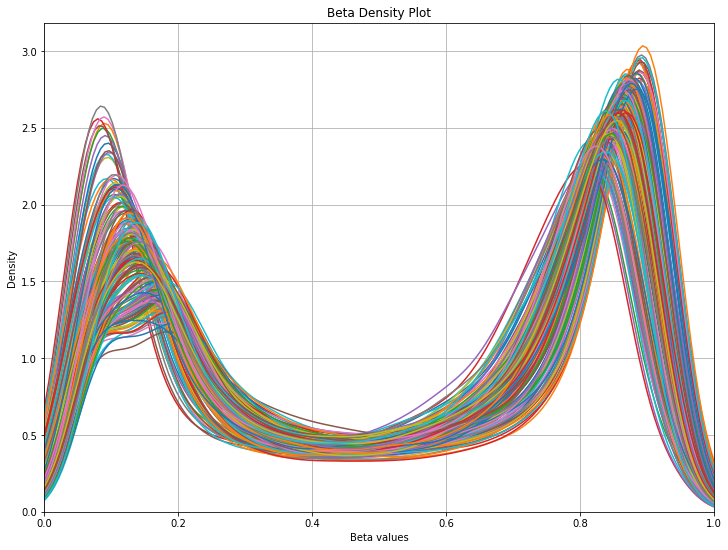

In [23]:
# plot the beta density distrubition before normalisation
pre_norm_BD = methylcheck.beta_density_plot(beta, return_fig=True)
pre_norm_BD.savefig(os.path.join(output_path, (identifier + "pre-normalisation beta density distribution.jpeg")))

In [24]:
import dasen_normalisation
test_normalised_betas_module = dasen_normalisation.dasen_normalisation(unmeth, meth, probe_type_data)
test_normalised_betas_module.to_csv(os.path.join(output_path, (identifier + "_normalised_betas.csv")))


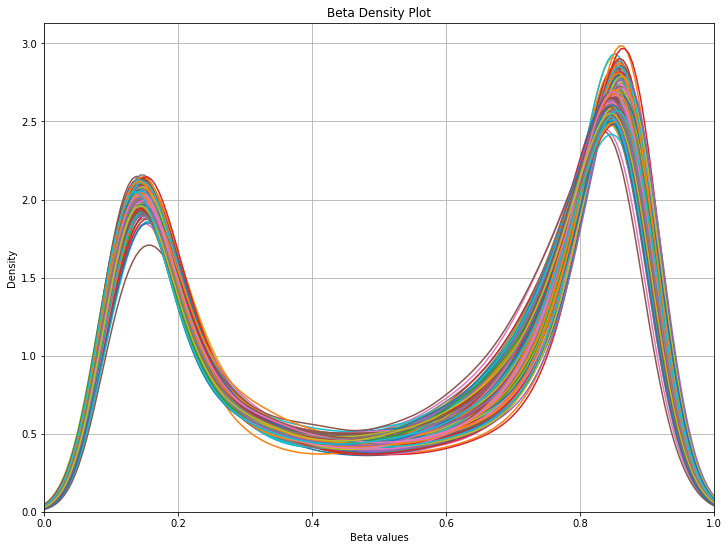

In [25]:
# confirm the beta density plot looks smoother after normalisation
post_norm_BD = methylcheck.beta_density_plot(test_normalised_betas_module, return_fig=True)
post_norm_BD.savefig(os.path.join(output_path, (identifier+ "post-normalisation beta density distribution.jpeg")))

In [27]:
# PCAs to check for batch effects on nomalised GSE66351 data
from sklearn.decomposition import PCA 
import matplotlib.pyplot as plt
import seaborn as sns
n_comp = 10
PCA = PCA(n_components=n_comp)
PCA_out = PCA.fit(test_normalised_betas_module)
#data_to_plot = pd.DataFrame({"PC4":PCA_out.components_[3], "PC5":PCA_out.components_[4], "Sentrix_ID":pheno.loc[:, "Sentrix_ID"]}, index=pheno.index.values)
#sns.lmplot(x="PC4", y = "PC5", hue="Sentrix_ID", data = data_to_plot, fit_reg=False)

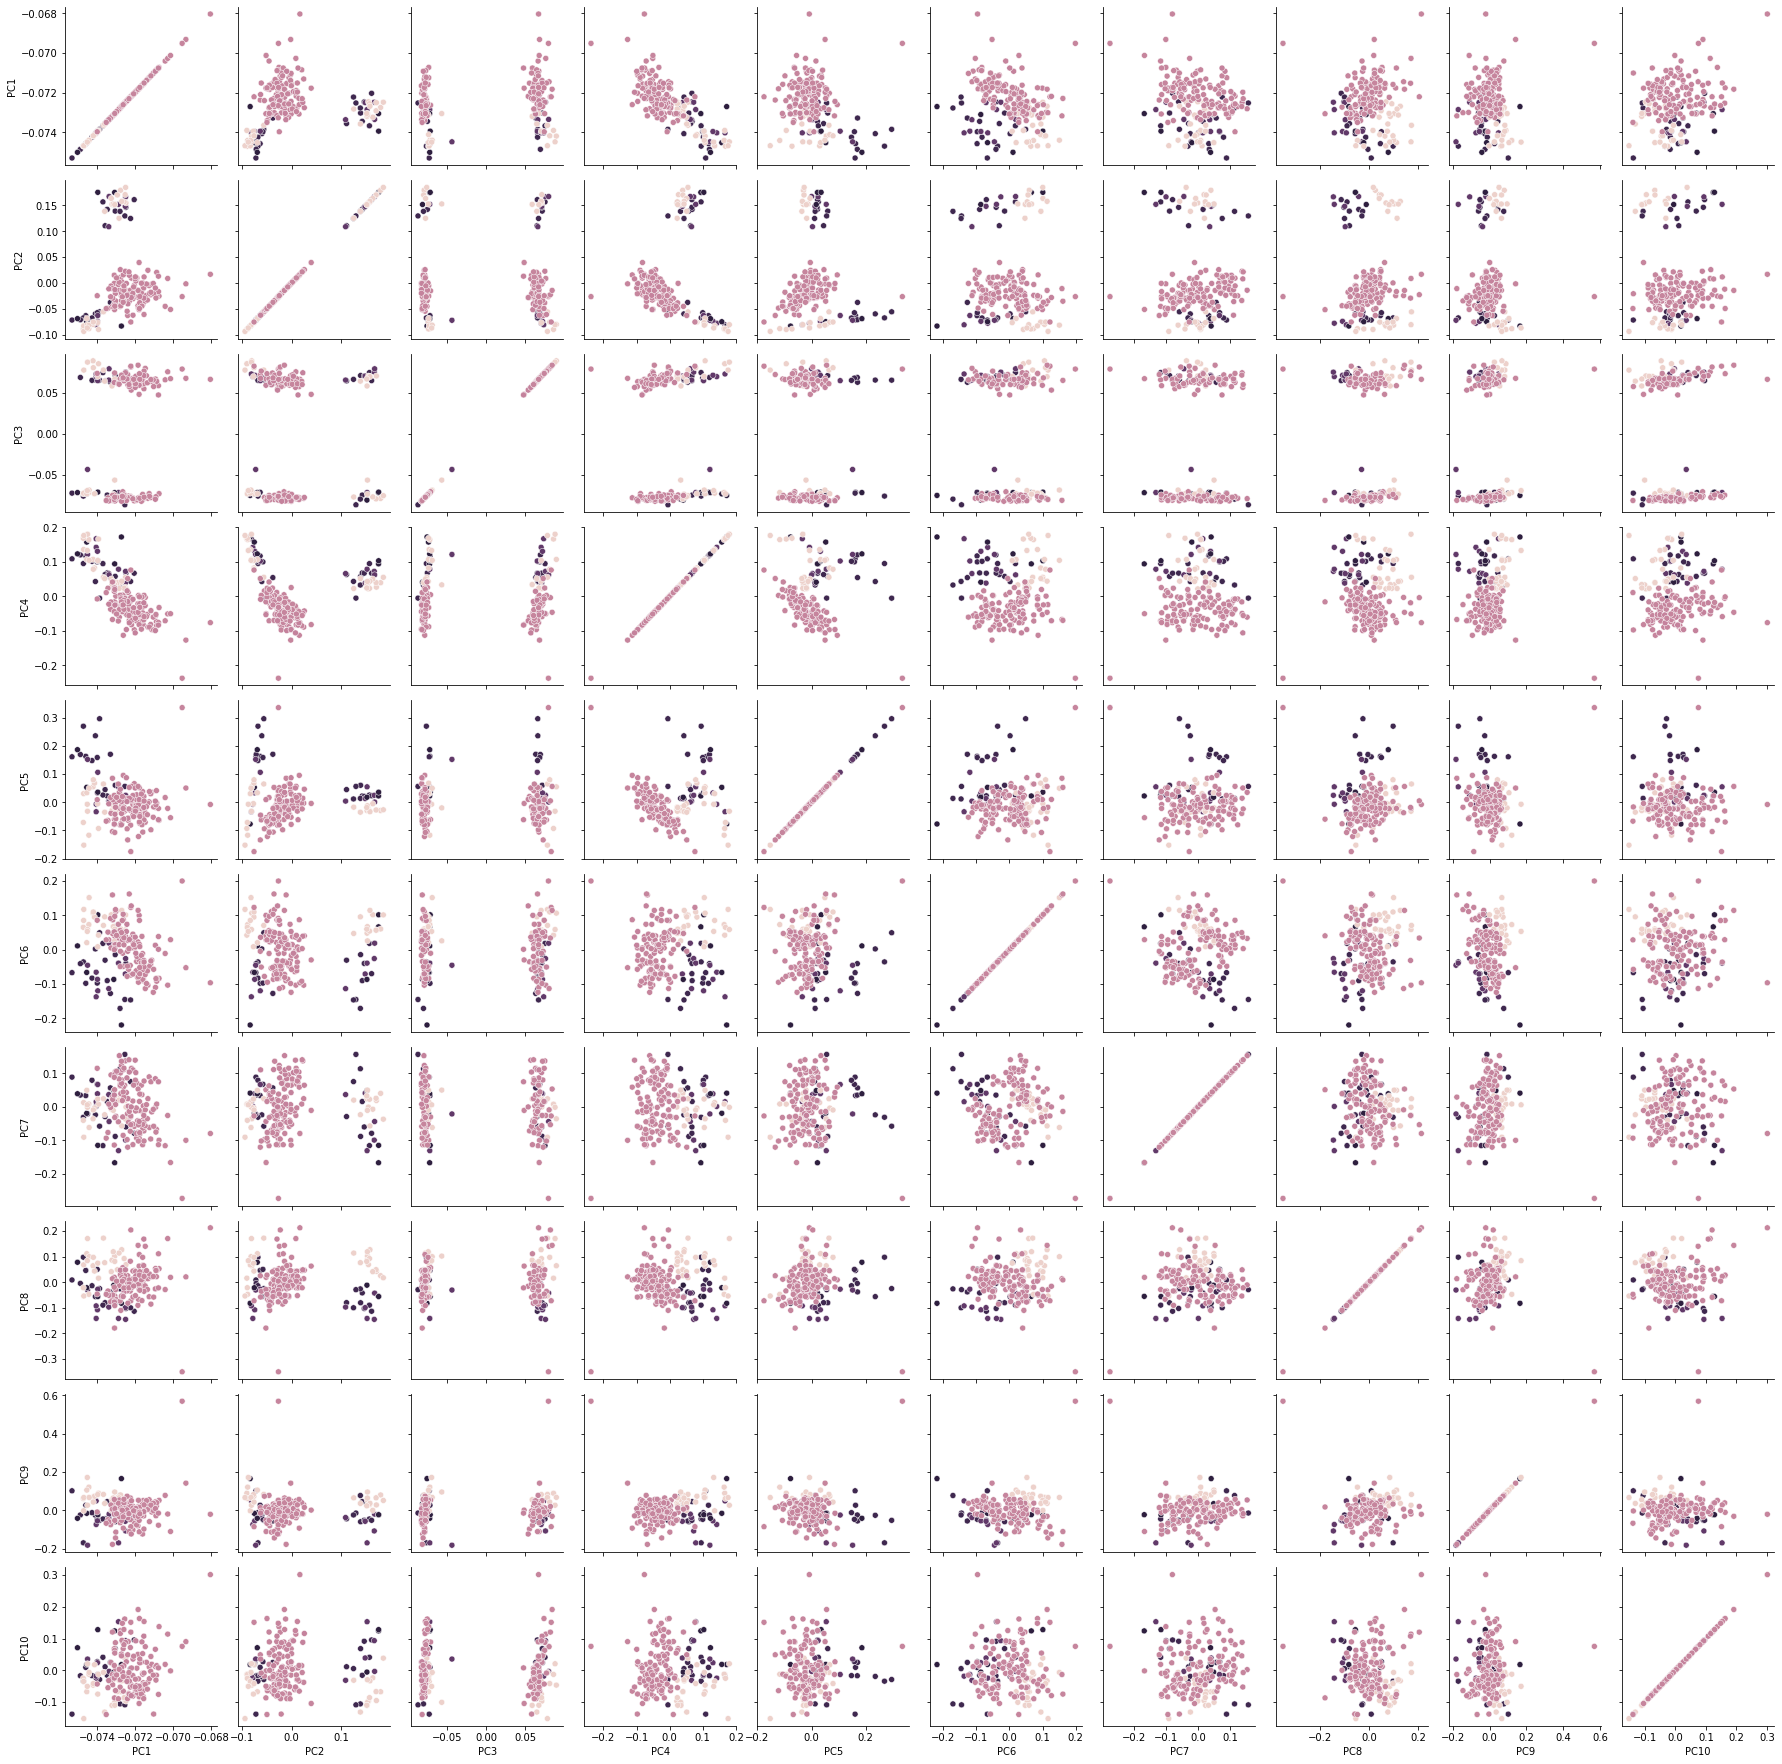

In [28]:
# exploratory grid plot to visualise the correlation between the PCs and Sentrix_ID
Principle_components = pd.DataFrame(PCA_out.components_.T, columns=["PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7", "PC8", "PC9", "PC10"], index=pheno.index)
data_to_plot = pd.concat([Principle_components, pheno.loc[:, "Sentrix_ID"]], axis = 1)
g = sns.PairGrid(data_to_plot, hue= "Sentrix_ID")
g.map(sns.scatterplot)
g.savefig(os.path.join(output_path, (identifier + "_Exploratory PCA grid coloured by Sentrix_ID.jpeg")))

The top correlated principle components with Sentrix_ID: 4 5


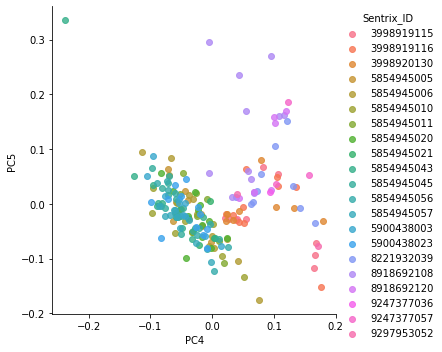

In [29]:
# calculate the correlation between the PC clusters and the Sentrix_ID variable
from scipy.stats import pearsonr
pca_iterator = np.arange(0, n_comp)
pca_cor = []
codes_sentrix, options_sentrix = pd.factorize(pheno.loc[:,"Sentrix_ID"])
for id, x in np.ndenumerate(pca_iterator):
    cor, p_value = pearsonr(PCA_out.components_[x,], codes_sentrix)
    pca_cor.append(float(cor)) # turn into list append
pc_output = pd.DataFrame({"PC": pca_iterator, "Correlation": pca_cor})
pc_output.sort_values(by = "Correlation", key = pd.Series.abs, ascending = False, inplace=True) #sort the correlation values in descending order based on their absolute value
first = abs(pc_output.iloc[0]) #get the two highest correlated PCs
second = abs(pc_output.iloc[1])
print("The top correlated principle components with Sentrix_ID:", first.name + 1, second.name + 1)

# visualise the two PCs with the strongest correlation with Sentrix_ID
data_to_plot = pd.DataFrame({"PC4":PCA_out.components_[int(first.name)], "PC5":PCA_out.components_[int(second.name)], "Sentrix_ID":pheno.loc[:, "Sentrix_ID"]},
     index=pheno.index.values)
detail_PCA = sns.lmplot(x="PC4", y = "PC5", hue="Sentrix_ID", data = data_to_plot, fit_reg=False)

In [30]:
detail_PCA.savefig(os.path.join(output_path, (identifier + "Highest correlating PCs with Sentrix_ID coloured by Sentrix_ID.jpeg")))

In [8]:
# correlation between sentrix_id and other phenotype information columns
cor_out = pheno.copy()
# select and prep the relevant columns
cor_out = pheno.loc[:, ["Diagnosis", "Braak_stage", "Brain_region", "Age", "Sex", "Donor_id", "sentrix_id", "M.median", "U.median"]]
cor_out["sentrix_id"] = cor_out.loc[:,"sentrix_id"].factorize()[0]
cor_out["Sex"] = cor_out.loc[:,"Sex"].factorize()[0]
cor_out["Donor_id"] = cor_out.loc[:,"Donor_id"].factorize()[0]
cor_out["Diagnosis"] = cor_out.loc[:,"Diagnosis"].factorize()[0]
cor_out[["Braak_stage", "Age", "M.median", "U.median"]] = cor_out[["Braak_stage", "Age", "M.median", "U.median"]].apply(pd.to_numeric, errors = "coerce")
cor_out.corr() 

,Diagnosis,Braak_stage,Age,Sex,Donor_id,sentrix_id,M.median,U.median
Diagnosis,1.000000,-0.899394,-0.447134,0.226236,-0.201060,-0.116368,-0.183287,0.024517
Braak_stage,-0.899394,1.000000,0.446084,-0.254429,0.292178,0.228290,0.187387,-0.119689
Age,-0.447134,0.446084,1.000000,-0.352889,0.085579,0.038249,0.081319,-0.012656
Sex,0.226236,-0.254429,-0.352889,1.000000,-0.032862,0.009932,-0.016282,-0.016236
Donor_id,-0.201060,0.292178,0.085579,-0.032862,1.000000,0.849569,0.043596,-0.256563
sentrix_id,-0.116368,0.228290,0.038249,0.009932,0.849569,1.000000,-0.021034,-0.377118
M.median,-0.183287,0.187387,0.081319,-0.016282,0.043596,-0.021034,1.000000,0.497654
U.median,0.024517,-0.119689,-0.012656,-0.016236,-0.256563,-0.377118,0.497654,1.000000


R script containing the RefFreeEWAS cell type decomposition which will be run in a subprocess, output saved and added to the phenotype information that will be used in the EWAS furhter down in this file

RefFreeEWAS with an RData file as input, this datafile has to contain the preprocessed and filtered betas together with the phenotype information

In [18]:
# specifying the paths that go into the subprocess function
file_path = os.path.join(working_path, "RefFreeEWAS_local.r") #this one requires .RData input
data_path = os.path.join(output_path, "QC_GSE66351", "preprocessed_MethyLumiSet.RData") #try again with different input data
manifest_path = "E:\\Msc Systems Biology\\MSB5000_Master_Thesis\\Practical work\\Data\\GSE66351_RAW\\GPL13534_HumanMethylation450_15017482_v.1.1.csv"
pheno_path = os.path.join(output_path, "QC_GSE66351", "pre_norm_pheno_information.csv")
output_dir = os.path.join(output_path, "QC_GSE66351")


# RefFreeEWAS subprocess
RefFreeEWAS_RData = subprocess.run(["C:\\Program Files\\R\\R-4.1.2\\bin\\Rscript.exe", '--vanilla', file_path, data_path, pheno_path, manifest_path, output_dir], capture_output=True)
RefFreeEWAS_RData.stdout

RefFreeEWAS for local input (.csv file with normalised betas)

In [34]:
# specifying the paths that go into the subprocess function
file_path = os.path.join(working_path, "RefFreeEWAS_local_csvinput.r") 
data_path = os.path.join(output_path, "QC_GSE66351", "Preprocessed_betas.csv") 
manifest_path = "E:\\Msc Systems Biology\\MSB5000_Master_Thesis\\Practical work\\Data\\GSE66351_RAW\\GPL13534_HumanMethylation450_15017482_v.1.1.csv"
pheno_path = os.path.join(output_path, "QC_GSE66351", "pre_norm_pheno_information.csv")
output_dir = os.path.join(output_path, "QC_GSE66351")


# RefFreeEWAS subprocess
RefFreeEWAS = subprocess.run(["C:\\Program Files\\R\\R-4.1.2\\bin\\Rscript.exe", '--vanilla', file_path, data_path, pheno_path, manifest_path, output_dir], capture_output=True)
RefFreeEWAS.stdout

EWAS code, based on the least squares linear algebra as used in the fortran code at the foundation of the lm() function in r

In [33]:
#EWAS
# load in the design matrix and beta values - GSE66351
design = pd.read_csv("E:\Msc Systems Biology\MSB5000_Master_Thesis\Practical work\Data\Data_Full_Datasets\GSE66351\Small_EWAS_design.csv", index_col=0)
betas = pd.read_csv("E:\\Msc Systems Biology\\MSB5000_Master_Thesis\\Practical work\\Data\\QC_Python\\GSE66351_normalised_betas.csv", index_col=0)
y = betas.iloc[0:21,:] # keeping it small now to test if everything works the way it should



In [31]:
import EWAS_central
results_diagnosis, results_ewas = EWAS_central.EWAS_central(design,test_normalised_betas_module)

In [32]:
# create an output table with the top (genomewide) significant probes and their associated gene with the metrics
gene_annotations = annotation_data.loc[:, "UCSC_RefGene_Name"]
gene_annotations = gene_annotations.loc[set(results_ewas.index.values).intersection(set(annotation_data.index.values))]
final_results_table = pd.DataFrame({"Associated Gene":gene_annotations, "Methylation Change":results_ewas.loc[:,("Coefficient", "Diagnosis")], "Corrected P-value":results_ewas.loc[:,("Corrected P-value", "Diagnosis")]})


In [33]:
final_results_table.sort_values(by = ["Corrected P-value"], inplace = True)

In [34]:
final_results_table.to_csv(os.path.join(output_path, (identifier + "results_diagnosis_regression_python.csv")))
results_ewas.to_csv(os.path.join(output_path, (identifier + "full_results_regression_python.csv")))

Create a .bed structured text file with the regression output to be used as input into the differentially methylated region analysis

In [63]:
# start with importing the probe information from the .bed file that is available through the encord project (?)
bed_annotation = pd.read_csv("E:\\Msc Systems Biology\\MSB5000_Master_Thesis\\Practical work\\Data\\HAIB.A549.EtOH.Rep.3.bed", sep="\t", header=None)
# select the three necessary column, chr, start, stop from the annotation file and match these to the probes in the EWAS input betas based on probe ID
bed_annotation = bed_annotation.iloc[:,0:4]
bed_annotation.columns = ["chr", "ChromStart", "ChromEnd", "Illumina_ID"]
# merge the regression output onto the .bed standard columns based on the probe ID
results_bed = pd.merge(bed_annotation, results_diagnosis, left_on="Illumina_ID", right_index=True, how="inner") #using inner join since this preserves the order of the keys and
# only keeps the entries that are present in both dataframes
results_bed.set_index(results_bed["Illumina_ID"], inplace=True)
# write the dataframe as a tab separated .bed file
results_bed.to_csv(os.path.join(output_path, (identifier + "results_diagnosis_regression_test.bed"), sep="\t"))

In [ ]:
def EWAS_central(design_matrix, beta_values):
    import numpy as np
    import pandas as pd
    import scipy.stats
    from statsmodels.stats.multitest import multipletests
    x_matrix = design_matrix.values
    y_matrix = beta_values.values


    n = y_matrix.shape[0] # select the number of rows of the beta matrix - #genes that the linear model will be calculated for
    m = x.shape[1] #select the number of columns from the design matrix

    

    coefficient = []
    standard_error = []
    t_stat = []
    p_value = []
    corrected_pvalue = []

    for i in range(0, n):
        y_m = y_matrix[i, :]
        x_t = x_matrix.T @ x_matrix
        x_t_y = x_matrix.T @ y_m
        x_t_inv = np.linalg.inv(x_t)
        coef = x_t_inv @ x_t_y
        coefficient.append(coef)
        stan_er = np.diag(x_t_inv)
        standard_error.append(stan_er)
        t = coef/stan_er
        t_stat.append(t)
        df = y_matrix.shape[1]-2 #degrees of freedom is defined as number of observations - 2 
        p = scipy.stats.t.sf(t, df)
        p_value.append(p)
    #turn the results saved in lists into a dataframe for each covariate with the probe ids as index
    for i in range(0,len(p_value)):
        corrected_pvalue.append(multipletests(p_value[i], method="fdr_bh")[1])
    results_corp = pd.DataFrame(corrected_pvalue, index=y.index, columns=x.columns)
    result_coef = pd.DataFrame(coefficient, index=y.index, columns=x.columns)
    result_staner = pd.DataFrame(standard_error, index = y.index, columns=x.columns)
    result_pvalue = pd.DataFrame(p_value, index=y.index, columns=x.columns)

    #create a final results dataframe that contains the coefficient, standard error and p-value of the diagnosis covariate included in the linear regression
    results_diagnosis = pd.DataFrame({"Diagnosis_Coef":result_coef["Diagnosis"], "Diagnosis_StanErr":result_staner["Diagnosis"],
        "Diagnosis_Pvalue":result_pvalue["Diagnosis"],
        "Diagnosis_CorP":results_corp["Diagnosis"]}, index=y.index)
    results_EWAS = pd.concat([result_coef, result_staner, result_pvalue, results_corp], axis = 1, keys = ["Coefficient", "Standard Error", "P-value", "Corrected P-value"])
    return results_diagnosis, results_EWAS